<a href="https://colab.research.google.com/github/skagnihotri/image_captioning/blob/master/IMG_CAPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/Gdrive', force_remount= True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/Gdrive


# Data Downloading

In [0]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:25<00:00, 44.0MB/s]
100% 1.04G/1.04G [00:25<00:00, 43.8MB/s]


In [0]:
!unzip /content/flickr8k.zip

# **Project Start**

### Libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import json
import pickle
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import *
from keras.layers.merge import add
from tqdm import tqdm

#####
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing Cap

In [0]:
df = pd.read_csv('/content/captions.txt')

In [9]:
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [10]:
df.tail()

,image,caption
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .
40454,997722733_0cb5439472.jpg,A rock climber practices on a rock climbing wa...


### Image captions dic

In [33]:
X = df.values
X[-1]

array(['997722733_0cb5439472.jpg',
       'A rock climber practices on a rock climbing wall .'], dtype=object)

In [0]:
# stopwords.words("english")

In [0]:
def Text_cleaning(s) :
    """" To clean the Text """
    s = s.lower()
    s = re.sub('[^a-z]+', " ", s)
    s = s.split()
    s = ' '.join(s)
    return s

In [62]:
all_img_cap = {}

for i in tqdm(X):
    if all_img_cap.get(i[0]) is None:
        all_img_cap[i[0]] = []

    all_img_cap[i[0]].append("startseq " + Text_cleaning(i[1]) + " endseq")

100%|██████████| 40455/40455 [00:00<00:00, 167950.51it/s]


In [63]:
all_img_cap['997722733_0cb5439472.jpg']

['startseq a man in a pink shirt climbs a rock face endseq',
 'startseq a man is rock climbing high in the air endseq',
 'startseq a person in a red shirt climbing up a rock face covered in assist handles endseq',
 'startseq a rock climber in a red shirt endseq',
 'startseq a rock climber practices on a rock climbing wall endseq']

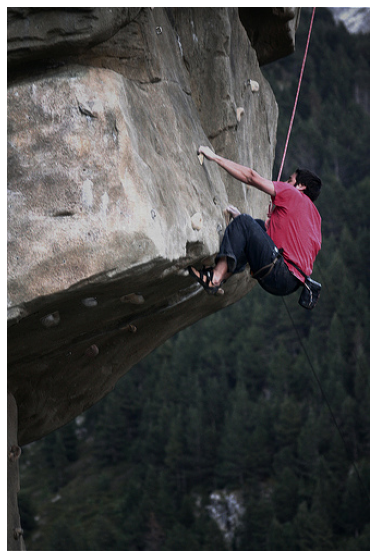

In [70]:
img = image.load_img('/content/Images/997722733_0cb5439472.jpg')

plt.figure(figsize= (10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [80]:
# creating a vocab

vocab = set()
all_words = []

for values in tqdm(all_img_cap.values()):
    for line in values:
        [vocab.add(word) for word in line.split()]
        [all_words.append(word) for word in line.split()]

100%|██████████| 8091/8091 [00:00<00:00, 38393.70it/s]


In [81]:
len(vocab), len(all_words)

(8443, 518339)

In [0]:
import collections

counter = collections.Counter(all_words)
freq_cnt = dict(counter)
freq_cnt = sorted(freq_cnt.items(), reverse= True, key= lambda x:x[1])

In [0]:
# Filter
threshold = 10
freq_cnt = [x for x in freq_cnt if x[1] >= threshold]
total_words = [x[0] for x in freq_cnt]

In [95]:
len(freq_cnt), len(total_words)

(1963, 1963)

## Image Feature Extraction